<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainSAPClassifier_04_NaiveBayes_fixed_vocab_smaller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import spacy
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [60]:
stats_vocab = set("""0	pe
1	sap
2	tabulated
3	hazard
4	inferiority
5	categorical
6	meddra
7	residual
8	itt
9	continuous
10	summarised
11	variables
12	brv
13	variable
14	cox
16	laz
17	statistics
18	descriptive
19	regression
20	proportional
21	hazards
22	sided
23	deviation
26	percentage
27	calculated
28	analysed
29	censored
30	derived
31	coding
32	cumulative
34	soc
38	covariates
39	survival
40	deviations
41	pv
42	interim
43	class
44	hypothesis
45	sensitivity
46	power
47	ratio
48	summarized
49	median
50	measurements
51	model
52	endpoint
53	exploratory
54	statistical
55	plan
56	confidence
57	log
58	ipm
59	estimate
60	planned
62	classified
63	95%
64	solicited
65	iu
66	significance
67	adjusted
68	pq
69	randomisation
70	ci
71	values
72	differences
73	measures
74	signed
75	outcomes
76	assigned
77	analyses
78	overview
79	intervals
81	measurement
82	90%
83	versus
84	analysis
85	point
86	adherence
87	interval
88	secondary
89	value
90	groups
91	estimated
92	mean
93	relative
94	treat
95	frequency
96	outcome
97	detect
98	discharge
99	distribution
100	baseline
101	endpoints
102	dsmb
103	objectives
104	efficacy
105	method
106	negative
112	ae
113	rate
116	cd
119	parameters
120	maximum
123	crf
124	type
126	incidence
127	defined
128	function
129	50%
152	vs
155	database
156	effect
159	saes
169	one
173	two
178	observed
179	version
180	measure
182	three
202	design
265	sample
282	criteria
283	examination
284	evaluated
286	similar
312	control
325	sae
394	50
426	95
447	90
462	records
465	management
473	documents
478	access
490	55""".split("\n"))
stats_vocab = set([re.sub(r'^\d+\s+', '', w) for w in stats_vocab])

In [61]:
tok = RegexpTokenizer(r'[a-zA-Z]+')

In [62]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [63]:
import operator
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [64]:
 del file_to_pages

In [65]:
df_annotations = df_annotations[~df_annotations.has_sap.isna()]

In [66]:
df_annotations["has_sap"].value_counts()

0    6150
1    5774
Name: has_sap, dtype: int64

In [67]:
df_train = df_annotations[df_annotations.train_val == "train"]
df_val = df_annotations[df_annotations.train_val == "val"]

In [68]:

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True, vocabulary=stats_vocab, min_df=5,
                             token_pattern=r'[59][05]%?(?:ci)?|[a-z][a-z]+')
transformer = TfidfTransformer()

nb = MultinomialNB()
model = make_pipeline(vectoriser, transformer, nb)

In [69]:
df_train_small = df_train.sample(100)

In [70]:
model.fit(df_train_small.text, df_train_small.has_sap)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=5,
                                 token_pattern='[59][05]%?(?:ci)?|[a-z][a-z]+',
                                 vocabulary={'50', '50%', '55', '90', '90%',
                                             '95', '95%', 'access', 'adherence',
                                             'adjusted', 'ae', 'analysed',
                                             'analyses', 'analysis', 'assigned',
                                             'baseline', 'brv', 'calculated',
                                             'categorical', 'cd', 'censored',
                                             'ci', 'class', 'classified',
                                             'coding', 'confidence',
                                             'continuous', 'control',
                                             'covariates', 'cox', ...})),
                ('tfidftransformer', TfidfTransformer()),
                ('multinom

In [71]:
df_val["y_pred"] = model.predict(df_val.text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
df_val["y_pred_proba"] = model.predict_proba(df_val.text)[:,1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
sap_ground_truths = df_val.has_sap
pred_sap = df_val.y_pred

In [74]:
acc = accuracy_score(sap_ground_truths, pred_sap)
print (f"SAP accuracy {acc}")

SAP accuracy 0.7815668202764977


''

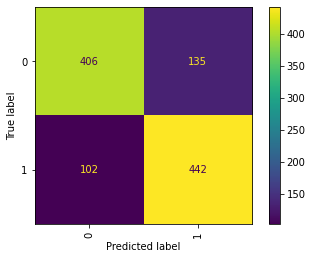

In [75]:
ConfusionMatrixDisplay.from_predictions(sap_ground_truths, pred_sap)
plt.xticks(rotation=90)
;

In [76]:
all_aucs = []
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(sap_ground_truths, pred_sap)
print (f"SAP ROC AUC {roc_auc}")

SAP ROC AUC 0.7814810536044361


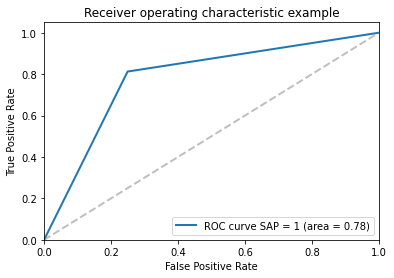

In [77]:
plt.figure()
lw = 2
    
for i in [1]:
    fpr, tpr, _ = roc_curve(sap_ground_truths, pred_sap)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=f"ROC curve SAP = {i} (area = {roc_auc:0.2f})"
    )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [78]:
fake_document = " ".join(vectoriser.vocabulary_)
vectorised_document = vectoriser.transform([fake_document])
transformed_document = transformer.transform(vectorised_document)
probas = np.zeros((transformed_document.shape[1]))

for prediction_idx in [1]:
      print(f"Strongest predictors for class {prediction_idx}\n")
      for i in range(transformed_document.shape[1]):
          zeros = np.zeros(transformed_document.shape)
          zeros[0, i] = transformed_document[0, i]
          proba = nb.predict_log_proba(zeros)
          probas[i] = proba[0, prediction_idx]

      for ctr, j in enumerate(np.argsort(-probas)):
          for w, i in vectoriser.vocabulary_.items():
              if i == j:
                  print(f"{ctr}\t{w}")


Strongest predictors for class 1

0	survival
1	sensitivity
2	estimate
3	hypothesis
4	50%
5	power
6	detect
7	residual
8	regression
9	outcomes
10	effect
11	versus
12	two
13	cox
14	differences
15	proportional
16	50
17	outcome
18	cd
19	vs
20	cumulative
21	pq
22	treat
23	median
24	groups
25	one
26	three
27	measure
28	evaluated
29	soc
30	55
31	version
32	negative
33	assigned
34	frequency
35	95%
36	management
37	similar
38	control
39	log
40	plan
41	adjusted
42	censored
43	discharge
44	pe
45	significance
46	hazard
47	function
48	deviation
49	distribution
50	90
51	estimated
52	criteria
53	overview
54	design
55	iu
56	statistical
57	measurement
58	continuous
59	sided
60	calculated
61	database
62	rate
63	90%
64	interval
65	observed
66	objectives
67	variables
68	95
69	dsmb
70	confidence
71	model
72	classified
73	ratio
74	point
75	intervals
76	incidence
77	access
78	maximum
79	deviations
80	ipm
81	brv
82	laz
83	defined
84	variable
85	solicited
86	interim
87	secondary
88	adherence
89	sap
90	type
91	d

In [80]:
import bz2
with bz2.open("sap_classifier_document_level.pkl.bz2", "wb") as f:
    pkl.dump(model, f)